# Import Library & Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')

DATASET_PATH = '../data/cleaned_data_saudi_used_cars.csv'
OUTPUT_PATH = '../data/cleaned_outliers_data_saudi_used_cars.csv'

In [2]:
df = pd.read_csv(DATASET_PATH)
display(df.head())

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
1,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
2,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
3,CX3,Abha,Mazda,Automatic,Saudi,Semi Full,2019,2.0,25000,False,58000
4,Cayenne S,Riyadh,Porsche,Automatic,Saudi,Full,2012,4.8,189000,False,85000


# Helper Functions for Visualization

For Numerical:

In [3]:
def plot_hist(series, bins, title, xlabel):
    plt.figure(figsize=(10, 5))
    sns.histplot(series, bins=bins, kde=True, color='#1976d2')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

def plot_box(series, title, xlabel):
    plt.figure(figsize=(10, 2))
    sns.boxplot(x=series, color='#1976d2')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()
    
def plot_numeric_relationship(
    df, 
    x_col, 
    y_col, 
    show_medians=True, 
    figsize=(12,6), 
    scatter_alpha=0.5,
    reg_color='red',
    median_color='green',
    median_label='Median Y',
    ylim=None,
    xlim=None,
    median_kwargs=None,
    reg_kwargs=None,
    title=None
):
    """
    Plots y_col vs. x_col with regression line and optional median y per unique x value.

    Args:
        df (pd.DataFrame): DataFrame with data.
        x_col (str): Name of x-axis column (must be numeric/discrete).
        y_col (str): Name of y-axis column.
        show_medians (bool): Plot median y per x if True.
        figsize (tuple): Figure size.
        scatter_alpha (float): Alpha for scatter.
        reg_color (str): Color for regression line.
        median_color (str): Color for median line.
        median_label (str): Legend label for median.
        ylim (tuple or None): Y-axis limits.
        xlim (tuple or None): X-axis limits.
        median_kwargs (dict or None): Additional kwargs for median line.
        reg_kwargs (dict or None): Additional kwargs for sns.regplot().
        title (str or None): Custom plot title.
    """
    plt.figure(figsize=figsize)
    # Regression and scatter
    regplot_kwargs = dict(
        x=x_col,
        y=y_col,
        data=df,
        scatter_kws={'alpha': scatter_alpha, 's': 24},
        line_kws={'color': reg_color},
    )
    if reg_kwargs:
        regplot_kwargs.update(reg_kwargs)
    sns.regplot(**regplot_kwargs)
    
    # Median line (for discrete/ordinal/nice integer x)
    if show_medians:
        unique_x = np.sort(df[x_col].unique())
        medians = df.groupby(x_col)[y_col].median().reindex(unique_x)
        mkws = dict(color=median_color, linewidth=2, markersize=8, label=median_label)
        if median_kwargs:
            mkws.update(median_kwargs)
        plt.plot(unique_x, medians, 'o-', **mkws)
        plt.legend()
    if title is not None:
        plt.title(title)
    else:
        plt.title(f'{y_col} vs. {x_col} (Regression{" & Median" if show_medians else ""})')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True, alpha=0.3)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.tight_layout()
    plt.show()

For Categorical:

In [4]:
def top_n_barplot(series, n=20, title=None, xlabel=None):
    counts = series.value_counts()
    plt.figure(figsize=(12, 6))
    counts.head(n).plot(kind='bar')
    plt.title(title or f'Top {n} Most Common')
    plt.ylabel('Count')
    plt.xlabel(xlabel or series.name)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    print("\nTop 20 most common Types:")
    print(counts.head(n))

def find_near_duplicates(series):
    raw = pd.Series(series.unique())
    suspect = raw[raw.str.strip().str.lower().duplicated(keep=False)]
    print(f"Possible near-duplicate or inconsistent names:\n{suspect}")

def pareto_coverage(series, target_pct=0.8):
    counts = series.value_counts()
    cumsum = counts.cumsum() / counts.sum()
    N_target = (cumsum >= target_pct).argmax() + 1
    label = (cumsum >= target_pct).idxmax()
    
    # Calculate percentages
    percentage_of_unique_types = (N_target / len(counts)) * 100
    top_n_percentage = cumsum.values[N_target-1] * 100
    
    print(f"\nTop {N_target} {series.name}s account for {int(target_pct*100)}% of the data. {int(target_pct*100)}th percentile: {label}")
    print(f"These top {N_target} models represent {percentage_of_unique_types:.2f}% of all unique values in this feature, and they represent {top_n_percentage:.2f}% of all cars in the dataset.")
    
    plt.figure(figsize=(10, 4))
    plt.plot(cumsum.values, label='Cumulative Coverage')
    plt.axhline(target_pct, color='r', linestyle='--', label=f'{int(target_pct*100)}% Coverage')
    plt.axvline(N_target, color='g', linestyle='--', label=f'N = {N_target}')
    plt.scatter(N_target, cumsum.values[N_target-1], color='g', zorder=5)
    plt.text(N_target, cumsum.values[N_target-1]+0.05, f'N={N_target}', color='g', ha='center')
    plt.title(f'Cumulative Coverage of {series.name} Frequency')
    plt.xlabel(f'Top N {series.name}s')
    plt.ylabel('Cumulative % of Data')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return N_target, label

def rare_categories(series, threshold=10):
    counts = series.value_counts()
    rare = counts[counts < threshold]
    pct = (len(rare) / len(counts)) * 100
    print(f"Rare {series.name}s (<{threshold} rows): {len(rare)} of {len(counts)} total ({pct:.2f}%)")
    if not rare.empty:
        print("Example rare values:", rare.head())
        
def feature_value_counts(series):
    print(f"Unique {series.name} values:", series.unique())
    value_counts = series.value_counts()
    print(value_counts)

    # Percentage breakdown
    print("\nPercentage breakdown:")
    value_percentages = (value_counts / value_counts.sum() * 100).round(2)
    print(value_percentages)

def plot_categorical_distribution(series):
    counts = series.value_counts()
    n_unique = counts.shape[0]
    default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    colors = default_colors[:min(n_unique, 4)]
    
    plt.figure(figsize=(7, 4))
    counts.plot(kind='bar', color=colors)
    plt.title(f'Distribution of {series.name}')
    plt.ylabel('Count')
    plt.xlabel(series.name)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
# ---- Helper for boxplot by category ----
def boxplot_by_category(df, cat_col, num_col='Price', top_n=None, sort_by_median=True, figsize=(16,6)):
    """
    Plots boxplot of num_col by cat_col, optionally only for the top_n most frequent categories,
    and optionally sorted by median of num_col.
    """
    counts = df[cat_col].value_counts()
    if top_n is not None:
        keep = counts.head(top_n).index
        data = df[df[cat_col].isin(keep)]
    else:
        data = df
    if sort_by_median:
        order = data.groupby(cat_col)[num_col].median().sort_values().index
    else:
        order = None
    plt.figure(figsize=figsize)
    sns.boxplot(x=cat_col, y=num_col, data=data, order=order, showfliers=True)
    plt.title(f'{num_col} by Top {top_n} {cat_col} (Sorted by Median)') if top_n else plt.title(f'{num_col} by {cat_col} (Sorted by Median)')
    plt.xlabel(cat_col)
    plt.ylabel(num_col)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Outliers Detection & Handling

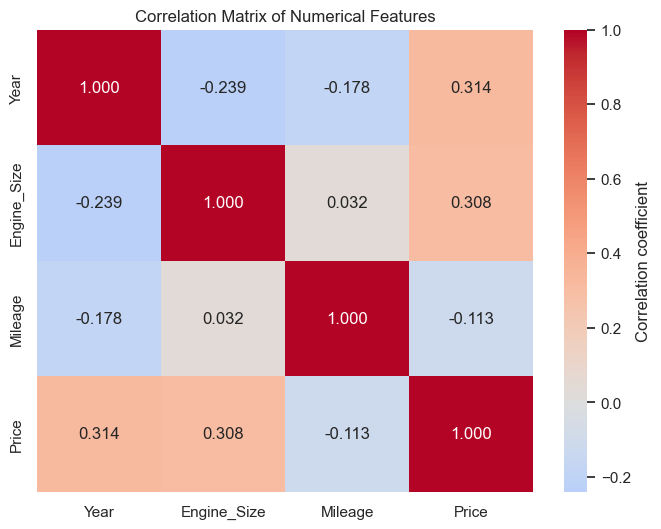

In [5]:
# Select only numerical columns (including 'Price')
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

corr = df[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".3f", cmap='coolwarm', center=0, 
            cbar_kws={'label': 'Correlation coefficient'})
plt.title("Correlation Matrix of Numerical Features")
plt.show()

(note: replace this with specific statistical correlation for each feature with price)

## Year

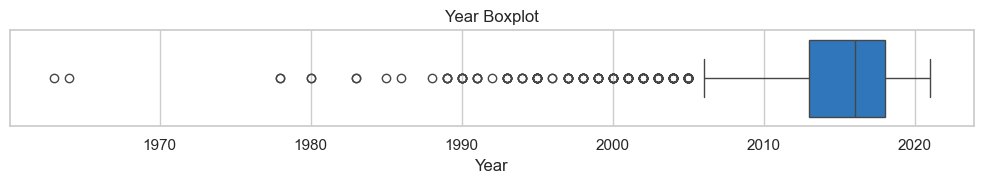

In [6]:
plot_box(df['Year'], title='Year Boxplot', xlabel='Year')

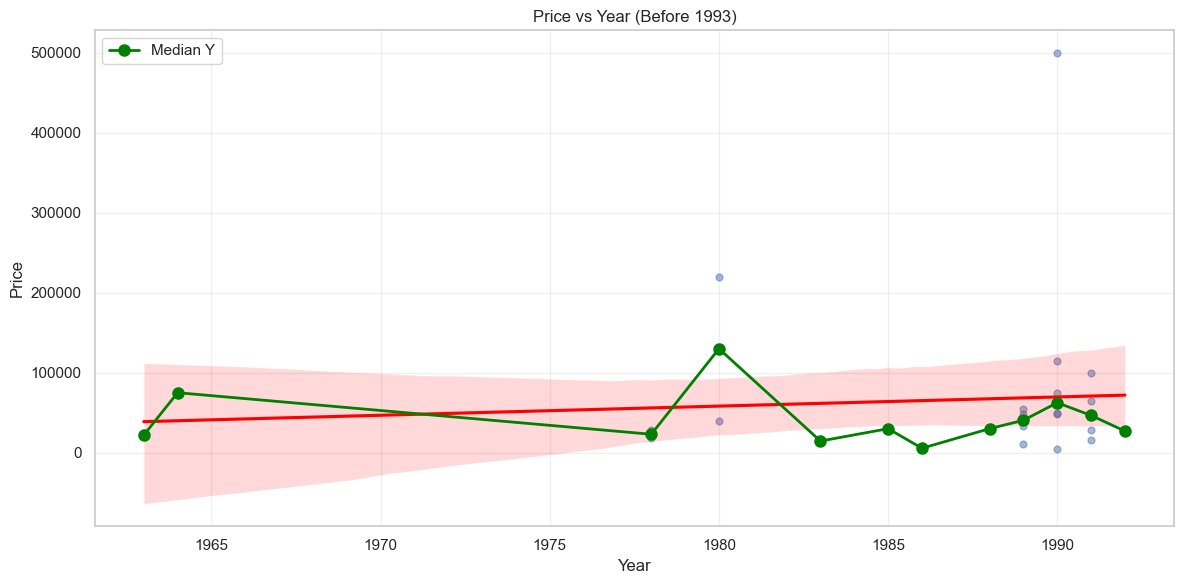

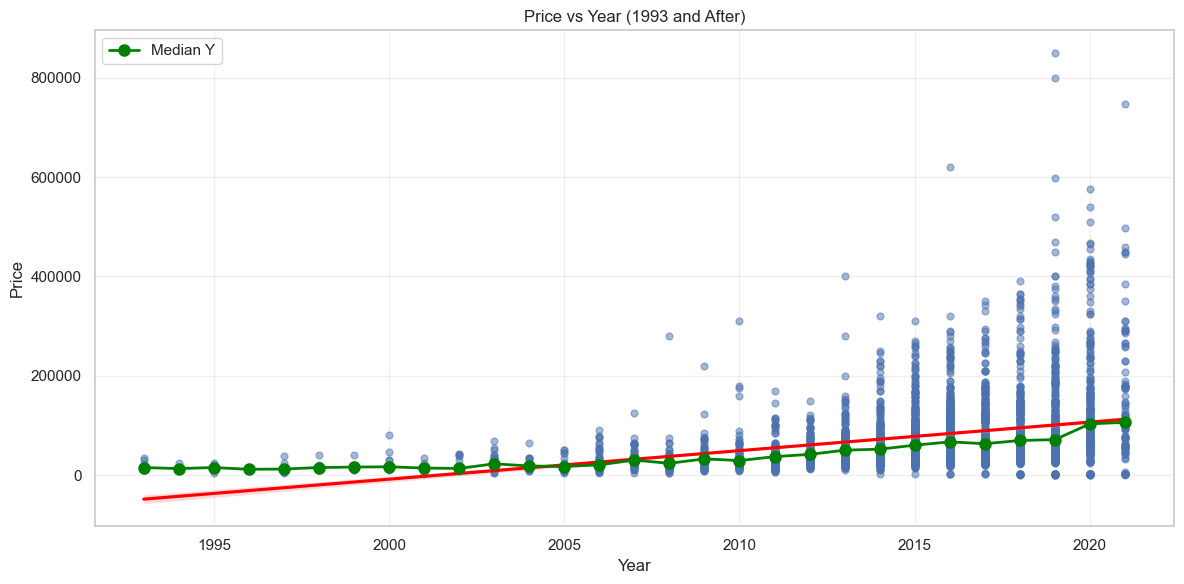

In [7]:
plot_numeric_relationship(df[df['Year'] < 1993], x_col='Year', y_col='Price', title='Price vs Year (Before 1993)')
plot_numeric_relationship(df[df['Year'] >= 1993], x_col='Year', y_col='Price', title='Price vs Year (1993 and After)')

In [8]:
vintage_cars = df[df['Year'] < 1993]
vintage_cars

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
42,SEL,Tabouk,Mercedes,Automatic,Saudi,Full,1986,3.0,500000,False,5500
205,Land Cruiser Pickup,Aseer,Toyota,Manual,Saudi,Standard,1983,1.5,2580,False,15000
287,SEL,Dammam,Mercedes,Automatic,Other,Full,1990,4.0,89000,False,75000
445,Other,Qassim,Other,Manual,Other,Standard,1980,2.4,2500,False,220000
961,Land Cruiser,Najran,Toyota,Manual,Saudi,Semi Full,1988,4.0,195000,False,30000
1339,Fleetwood,Al-Ahsa,Cadillac,Automatic,Other,Full,1991,5.7,91000,False,65000
1533,Impala,Al-Ahsa,Chevrolet,Automatic,Other,Full,1964,1.2,100000,False,75000
1788,Suburban,Aseer,GMC,Automatic,Saudi,Semi Full,1990,3.5,140000,False,5000
1882,The 7,Dammam,BMW,Automatic,Other,Full,1989,5.0,67000,False,48000
2068,Camargue,Dammam,Rolls-Royce,Automatic,Saudi,Full,1990,6.7,5000,False,500000


In [9]:
print(len(vintage_cars), "vintage cars found (Year < 1993).")

26 vintage cars found (Year < 1993).


Vintage cars make up 0.68% of all cars.


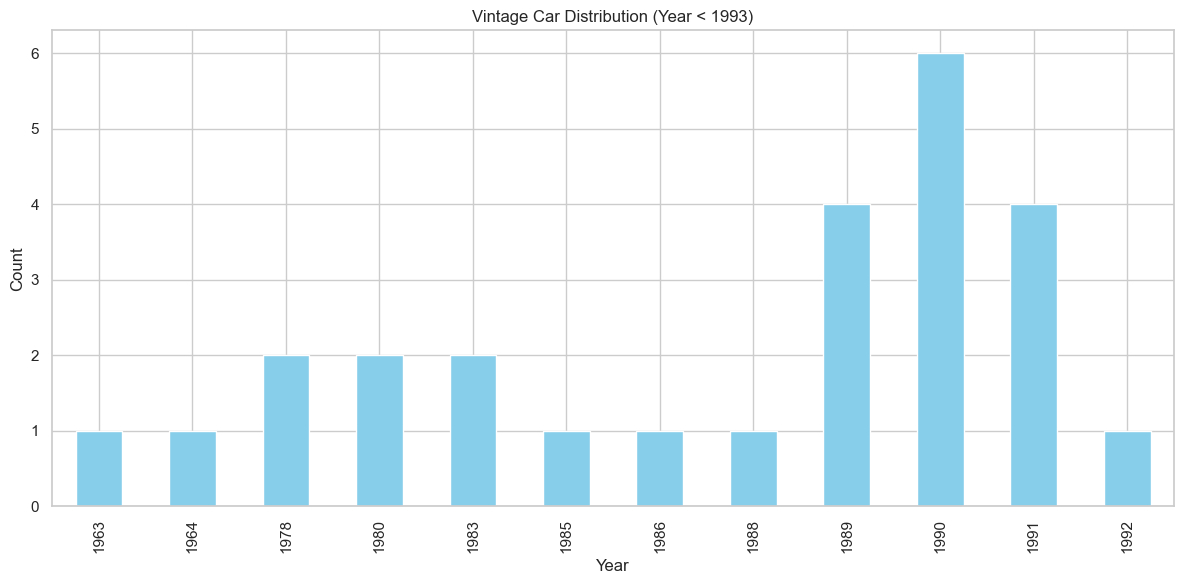

In [10]:
# ---- Vintage cars: Year < 1993 (at least 30 years old) ----
vintage_cars = df[df['Year'] < 1993]
vintage_percentage = len(vintage_cars) / len(df) * 100
print(f"Vintage cars make up {vintage_percentage:.2f}% of all cars.")
vintage_cars['Year'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Vintage Car Distribution (Year < 1993)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### Vintage Cars (Year < 1993)

Listings with manufacturing years before 1993 (30 years old and older) represent a small portion of the dataset and exhibit irregular pricing patterns that differ significantly from the modern used-car market. While these entries may be considered outliers due to their age and atypical behavior, they are retained in the dataset. Ideally, these rows are removed since it is a different scope than the normal used cars market and it would need a specialized model for vintage cars.

However, with limited options and keeping in mind the requirement of the project, instead of removing them, I will instead introduce a dedicated `IsVintage` feature during feature engineering to help the model recognize and handle these cases separately without distorting the learning process for the majority of listings. This way, the model will still be able to handle these values in the real world data.

## Engine Size

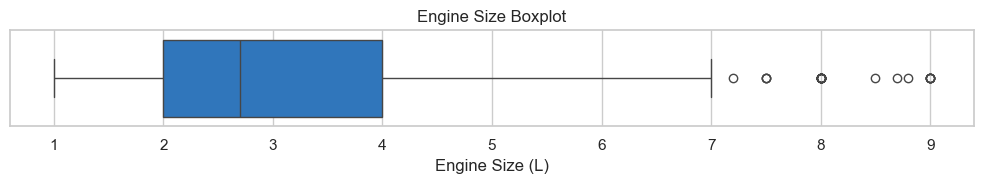

In [11]:
plot_box(df['Engine_Size'], title='Engine Size Boxplot', xlabel='Engine Size (L)')

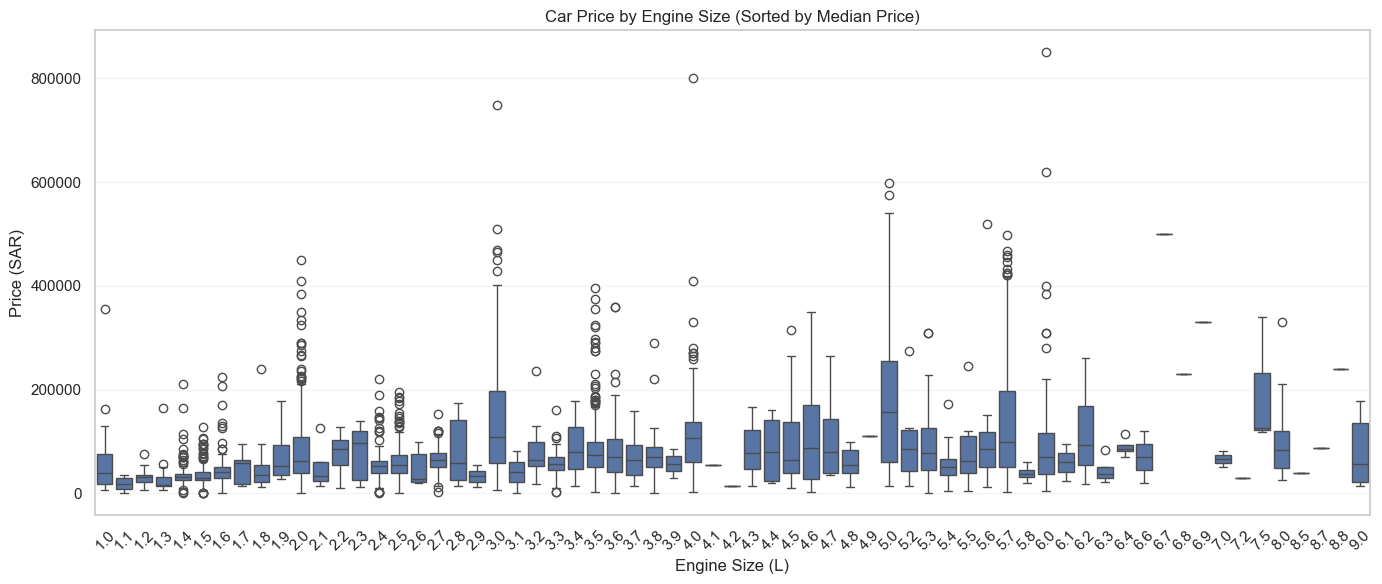

In [12]:
# Plot with sorted order
plt.figure(figsize=(14, 6))
sns.boxplot(
    x='Engine_Size',
    y='Price',
    data=df,
    showfliers=True
)
plt.title('Car Price by Engine Size (Sorted by Median Price)')
plt.xlabel('Engine Size (L)')
plt.ylabel('Price (SAR)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()

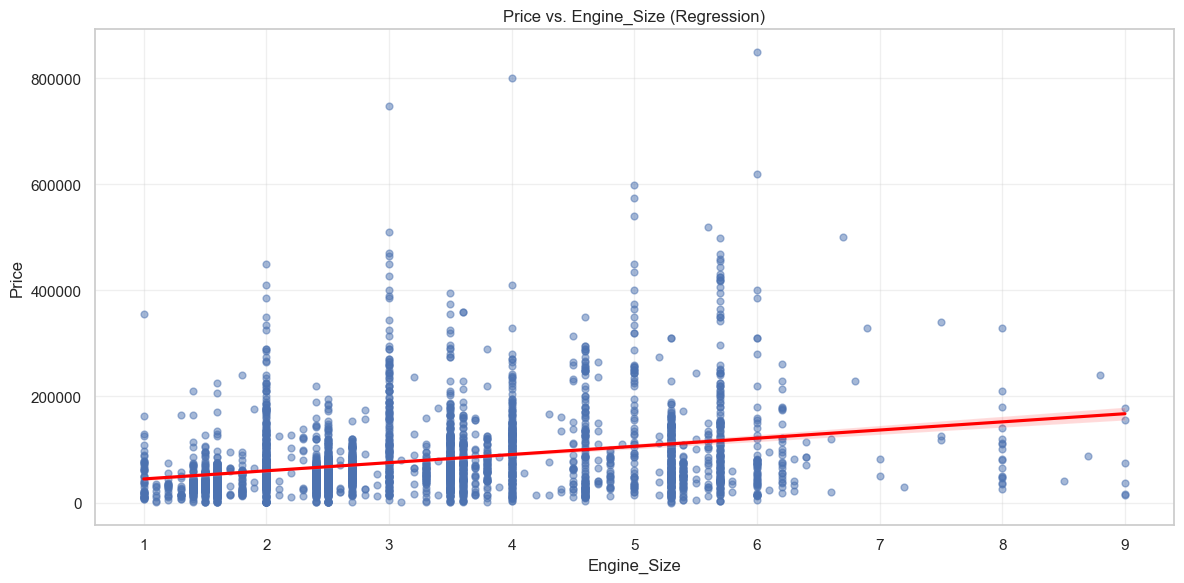

In [13]:
plot_numeric_relationship(df, x_col='Engine_Size', y_col='Price', show_medians=False)

There is no problem on the left tail of Engine Size distribution. Normal cars have engine size ranging from 1.0-3.0L, while high-end / luxury cars can have an engine size as high as 7.0L. For example, [Rolls-Royce Camargue is produced with an engine size of around 6.75L](https://www.automobile-catalog.com/model/rolls-royce/camargue.html), matching the data that we have.

In [14]:
df[df['Make'] == 'Rolls-Royce']

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
370,Ghost,Dammam,Rolls-Royce,Automatic,Saudi,Full,2010,6.0,175000,False,310000
1438,Ghost,Dammam,Rolls-Royce,Automatic,Saudi,Full,2016,6.0,40000,False,620000
2068,Camargue,Dammam,Rolls-Royce,Automatic,Saudi,Full,1990,6.7,5000,False,500000


There are also some concerning data points that doesn't match the typical pattern in Price vs Engine Size. For example, there is a 800k SAR car with only an engine size of 4.0

In [15]:
df[df['Price'] > 500000].sort_values(by='Price', ascending=False)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
2401,Bentayga,Dammam,Bentley,Automatic,Saudi,Full,2019,6.0,13000,False,850000
3191,G,Riyadh,Mercedes,Automatic,Other,Full,2019,4.0,39000,False,800000
2912,S,Dammam,Mercedes,Automatic,Gulf Arabic,Full,2021,3.0,2500,False,748000
1438,Ghost,Dammam,Rolls-Royce,Automatic,Saudi,Full,2016,6.0,40000,False,620000
3173,Range Rover,Riyadh,Land Rover,Automatic,Other,Full,2019,5.0,4200,False,599000
2435,Range Rover,Riyadh,Land Rover,Automatic,Saudi,Full,2020,5.0,26000,False,575000
2112,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2020,5.0,36000,False,540000
1956,Range Rover,Riyadh,Land Rover,Automatic,Saudi,Full,2019,5.6,36000,False,520000
1711,Range Rover,Riyadh,Land Rover,Automatic,Saudi,Full,2020,3.0,11500,False,510000


After taking a look at those concerning data points, it appears that those 'outliers' are actually luxury cars (e.g. Bentley, Rolls-Royce) that demand high prices due to their brand, even with small engine size. These data points should either be removed or flagged, or I can try to train the model to distinguish prices by the Make/Type of the car.

Although cars with engine size higher than 7.0L exist, they are quite rare and most likely customized/not built for regular/usual use. So, I need to inspect these 'extreme' values of engine size.

In [16]:
big_engine_cars = df[df['Engine_Size'] > 7.0]
big_engine_cars

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
39,Camry,Taef,Toyota,Automatic,Saudi,Semi Full,2001,9.0,150000,False,15000
402,G,Riyadh,Mercedes,Automatic,Saudi,Full,2015,8.8,213000,False,240000
437,E,Jeddah,Mercedes,Manual,Other,Semi Full,2017,9.0,134000,False,155000
505,LX,Taef,Lexus,Automatic,Gulf Arabic,Full,2018,7.5,122000,False,340000
603,Cadillac,Riyadh,Classic,Automatic,Saudi,Full,1995,8.0,119,False,25000
653,D-MAX,Abha,Isuzu,Manual,Saudi,Full,2019,7.5,40000,False,125000
716,F150,Riyadh,Ford,Automatic,Saudi,Standard,2014,8.0,147000,False,80000
786,Land Cruiser,Hail,Toyota,Automatic,Saudi,Full,2008,8.0,295000,False,65000
813,Other,Qassim,Other,Manual,Other,Full,2019,8.0,24643,False,330000


In [17]:
big_engine_cars['Make'].value_counts()

Make
Toyota        6
GMC           5
Chevrolet     5
Mercedes      3
Isuzu         2
Ford          2
Lexus         1
Classic       1
Other         1
Cadillac      1
Land Rover    1
Jeep          1
Dodge         1
Name: count, dtype: int64

In [18]:
big_engine_cars[big_engine_cars['Type'] == 'Camry']

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
39,Camry,Taef,Toyota,Automatic,Saudi,Semi Full,2001,9.0,150000,False,15000
1498,Camry,Jeddah,Toyota,Automatic,Saudi,Semi Full,2014,9.0,106000,False,36000


If we take Toyota Camry for example, which is listed with a 9.0L engine in the data above, it doesn't quite match with the normally produced Toyota Camry. The biggest engine size in a normal Toyota Camry I could find on the internet is a [2021 Toyota Camry with an engine size of 3.5L](https://www.toyotaofanaheim.com/2021-toyota-camry-engine-specs/#:~:text=Horsepower%20of%20the%20Camry,the%20power%20you%27d%20expect.).

However, there is still a possibility that there are customized cars (with engine swapped) being sold on the website, and removing cars with engine size > 7.0L might ended up removing valid cars (e.g. Customized Rolls-Royce can easily touch 7.0L engine size, added with the existence of almost 9.0L produced Rolls-Royce).

So, instead of removing these 'outliers', I'll tag them instead so the model know that these engine sizes are unnatural.

#### Large Engine Size Outliers Summary

A small number of listings in the dataset report exceptionally large engine sizes (> 7.0L), which exceed the typical range found in most production vehicles. While these values may reflect rare high-performance, customized, or imported models, they can be considered outliers relative to the mainstream market.

Instead of removing these listings, I retain them and introduce an `IsBigEngine` binary feature (1 if Engine_Size > 7.0L, else 0) in the next Feature Engineering section. This approach preserves potentially valuable information about rare, high-engine-capacity vehicles without allowing these outliers to distort price predictions for the majority of listings.

## Mileage

Based on the latest data, it is assumed that [the national average vehicle kilometers traveled (VKT) in Saudi Arabia is 25.000 kilometers 
(km) per car](https://www.kapsarc.org/wp-content/uploads/2023/06/KS-2023-DP13-Estimating-Regional-Variation-in-Saudi-Arabias-Energy-Usage-and-Carbon-Emissions.pdf).

In [19]:
with pd.option_context('display.float_format', '{:,.2f}'.format):
    print("Mileage descriptive stats:")
    print(df['Mileage'].describe())
    
print("Lowest 5 mileage values:")
print(df['Mileage'].nsmallest(5))
print("Highest 5 mileage values:")
print(df['Mileage'].nlargest(5))

Mileage descriptive stats:
count        3,824.00
mean       142,621.11
std        378,394.15
min            100.00
25%         48,000.00
50%        103,000.00
75%        183,000.00
max     20,000,000.00
Name: Mileage, dtype: float64
Lowest 5 mileage values:
156     100
574     100
762     100
863     100
2093    100
Name: Mileage, dtype: int64
Highest 5 mileage values:
2320    20000000
384      4500000
2859     3640000
955      3500000
3097     3300000
Name: Mileage, dtype: int64


There are possible anomalies if we look at the descriptive statistics for Mileage. For example, there are many cars with only 100km mileage, while there's also a car with 20 million km mileage, which means the car has been running for 800 years(!) if we are using the national average VKT. This kind of value is impossible and should be removed.

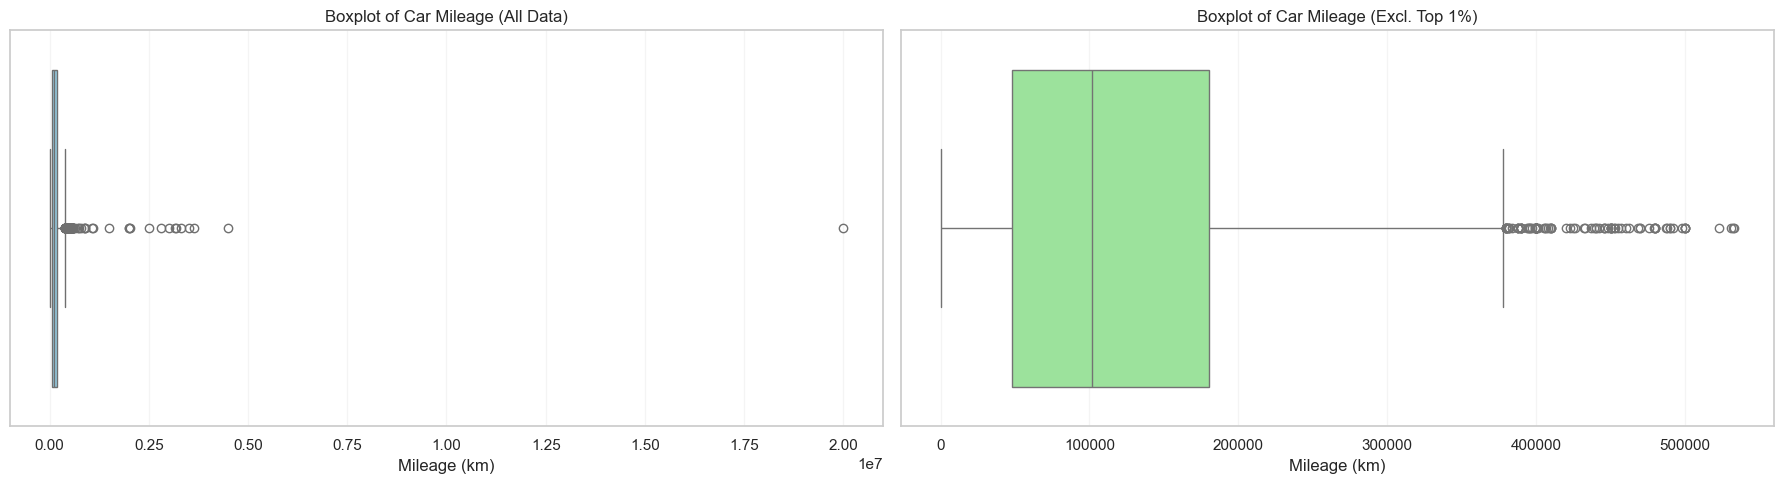

In [20]:
plt.figure(figsize=(18, 5))

# Full data boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x=df['Mileage'], color='skyblue')
plt.title('Boxplot of Car Mileage (All Data)')
plt.xlabel('Mileage (km)')
plt.grid(axis='x', alpha=0.2)

# Exclude top 1%
mileage_99 = df['Mileage'].quantile(0.99)
plt.subplot(1, 2, 2)
sns.boxplot(x=df[df['Mileage'] <= mileage_99]['Mileage'], color='lightgreen')
plt.title('Boxplot of Car Mileage (Excl. Top 1%)')
plt.xlabel('Mileage (km)')
plt.grid(axis='x', alpha=0.2)

plt.tight_layout()
plt.show()

In [21]:
national_mean_VKT = 25000  # km/year
small_mileage_cars = df[df['Mileage'] < national_mean_VKT]
big_mileage_cars = df[df['Mileage'] > 400000]

In [22]:
small_mileage_cars.sort_values(by='Mileage', ascending=True).head(20)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
863,Delta,Aseer,Daihatsu,Manual,Saudi,Full,2014,3.7,100,False,35000
2890,CT4,Jeddah,Cadillac,Automatic,Gulf Arabic,Semi Full,2020,3.7,100,False,159000
2093,Defender,Jeddah,Land Rover,Automatic,Saudi,Full,2021,3.0,100,False,450000
3405,Sonata,Jeddah,Hyundai,Automatic,Saudi,Standard,2020,2.5,100,False,72910
574,Yaris,Yanbu,Toyota,Automatic,Saudi,Standard,2016,1.5,100,False,32000
3563,Sierra,Dammam,GMC,Automatic,Saudi,Full,2021,9.0,100,False,178000
3093,S,Dammam,Mercedes,Automatic,Saudi,Semi Full,2000,3.0,100,False,15000
156,Sonata,Jeddah,Hyundai,Automatic,Saudi,Standard,2020,2.4,100,False,72910
2382,Cadenza,Tabouk,Kia,Automatic,Gulf Arabic,Full,2016,3.3,100,False,77000
762,CT5,Jeddah,Cadillac,Automatic,Gulf Arabic,Semi Full,2021,2.0,100,False,179000


In [23]:
big_mileage_cars.sort_values(by='Mileage', ascending=False).head(20)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
2320,Optra,Riyadh,Chevrolet,Manual,Other,Semi Full,2009,1.6,20000000,False,9000
384,Camry,Yanbu,Toyota,Automatic,Other,Full,1998,2.5,4500000,False,15000
2859,Innova,Riyadh,Toyota,Manual,Saudi,Standard,2013,2.7,3640000,False,30000
955,Trailblazer,Jeddah,Chevrolet,Automatic,Other,Full,2004,5.3,3500000,False,10000
3097,Tahoe,Riyadh,Chevrolet,Automatic,Saudi,Semi Full,2008,5.7,3300000,False,27000
623,Pathfinder,Riyadh,Nissan,Automatic,Saudi,Standard,1998,3.5,3180003,False,10500
3316,Pathfinder,Riyadh,Nissan,Automatic,Saudi,Full,2008,2.6,3150000,False,20000
2308,Fusion,Hail,Ford,Automatic,Saudi,Full,2010,2.5,3000000,False,17000
898,Prado,Makkah,Toyota,Manual,Saudi,Semi Full,2006,4.0,2800000,False,35000
2598,Marquis,Riyadh,Ford,Automatic,Saudi,Semi Full,2005,4.6,2500000,False,9000


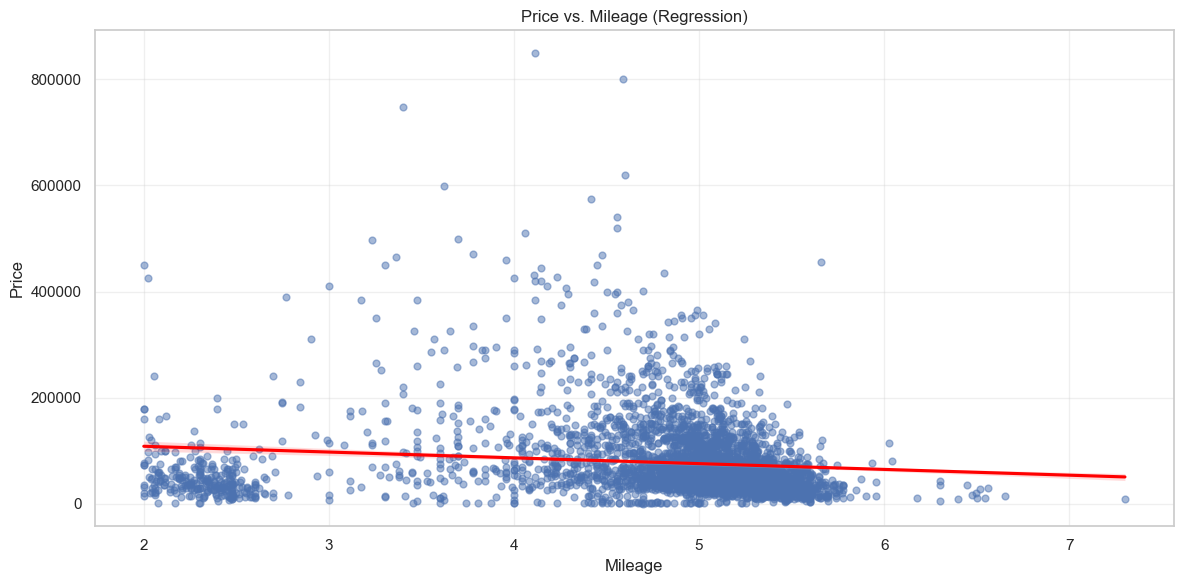

In [24]:
temp_df = df[['Mileage', 'Price']].copy()
temp_df['Mileage'] = np.log10(temp_df['Mileage'])
plot_numeric_relationship(temp_df, x_col='Mileage', y_col='Price', show_medians=False)

#### Outlier Detection with Mileage per Year

To improve data quality and avoid removing rare but valid older vehicles, we use `Mileage per Year` (total mileage divided by age) as an additional check for outlier detection. Listings with implausibly high usage rates (e.g., >100.000 km/year) are flagged and removed as appropriate. After cleaning, we retain and use total mileage as the primary input for modeling, as it is the most intuitive and relevant metric for buyers and sellers in the Saudi used-car market.

Low mileage (even very low like 100km) will be left as is, as a low mileage is still a realistic case especially for people who buy cars only for collecting and/or reselling purposes.

In [25]:
current_year = 2022  # dataset's latest year
car_ages = current_year - df['Year']

In [26]:
temp_df = df.copy()

In [27]:
temp_df['Mileage_per_Year'] = temp_df['Mileage'] / car_ages.replace(0, 1)

In [28]:
with pd.option_context('display.float_format', '{:,.2f}'.format):
    print(temp_df['Mileage_per_Year'].describe())

count       3,824.00
mean       20,245.35
std        30,467.35
min             4.26
25%        10,653.85
50%        18,354.17
75%        26,385.84
max     1,538,461.54
Name: Mileage_per_Year, dtype: float64


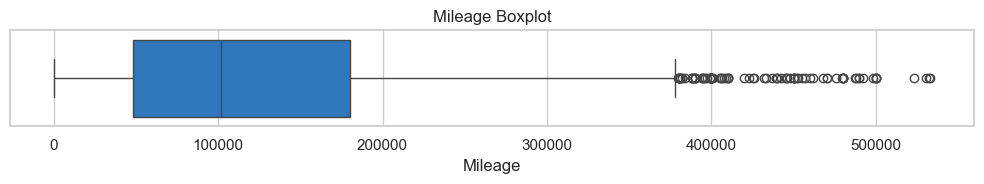

In [29]:
plot_box(df.loc[df['Mileage'] <= np.percentile(df['Mileage'], 99), 'Mileage'], title='Mileage Boxplot', xlabel='Mileage')

In [30]:
# Detect high-usage outliers
temp_df['Unnatural_High_Mileage_Flag'] = temp_df['Mileage_per_Year'] > (national_mean_VKT * 4) # 100 thousand km/year
temp_df['Unnatural_High_Mileage_Flag'].value_counts()

Unnatural_High_Mileage_Flag
False    3805
True       19
Name: count, dtype: int64

In [31]:
cols = ['Type', 'Origin', 'Year', 'Engine_Size', 'Mileage', 'Price', 'Mileage_per_Year', 'Unnatural_High_Mileage_Flag']
with pd.option_context('display.float_format', '{:,.2f}'.format):
    display(temp_df[temp_df['Unnatural_High_Mileage_Flag']][cols].sort_values(by='Mileage_per_Year', ascending=False))

,Type,Origin,Year,Engine_Size,Mileage,Price,Mileage_per_Year,Unnatural_High_Mileage_Flag
2320,Optra,Other,2009,1.60,20000000,9000,"1,538,461.54",True
2859,Innova,Saudi,2013,2.70,3640000,30000,"404,444.44",True
298,Azera,Saudi,2018,3.50,1100000,80000,"275,000.00",True
1434,Optima,Saudi,2014,2.50,2002500,42000,"250,312.50",True
2308,Fusion,Saudi,2010,2.50,3000000,17000,"250,000.00",True
3097,Tahoe,Saudi,2008,5.70,3300000,27000,"235,714.29",True
2166,LX,Gulf Arabic,2020,5.70,455000,455000,"227,500.00",True
3316,Pathfinder,Saudi,2008,2.60,3150000,20000,"225,000.00",True
955,Trailblazer,Other,2004,5.30,3500000,10000,"194,444.44",True
384,Camry,Other,1998,2.50,4500000,15000,"187,500.00",True


These 19 listings represent cars with an 'impossible' rate of mileage, making these cars seem dubious and can very much be invalid listings (data-entry errors, etc.). Therefore, we will remove these listings as to not ruin the pattern for the predictive models.

In [32]:
df_clean_mileage = temp_df[~temp_df['Unnatural_High_Mileage_Flag']].copy()
print(df_clean_mileage.info())
print(df_clean_mileage['Unnatural_High_Mileage_Flag'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 3805 entries, 0 to 3823
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Type                         3805 non-null   object 
 1   Region                       3805 non-null   object 
 2   Make                         3805 non-null   object 
 3   Gear_Type                    3805 non-null   object 
 4   Origin                       3805 non-null   object 
 5   Options                      3805 non-null   object 
 6   Year                         3805 non-null   int64  
 7   Engine_Size                  3805 non-null   float64
 8   Mileage                      3805 non-null   int64  
 9   Negotiable                   3805 non-null   bool   
 10  Price                        3805 non-null   int64  
 11  Mileage_per_Year             3805 non-null   float64
 12  Unnatural_High_Mileage_Flag  3805 non-null   bool   
dtypes: bool(2), float64(2),

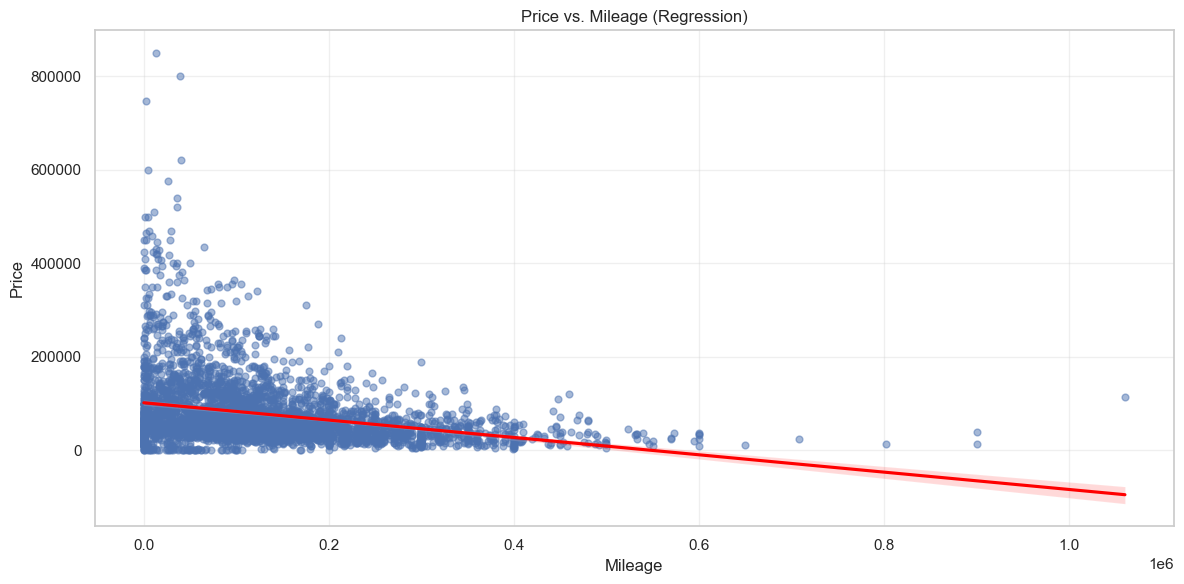

In [33]:
plot_numeric_relationship(df_clean_mileage, x_col='Mileage', y_col='Price', show_medians=False)

## Price

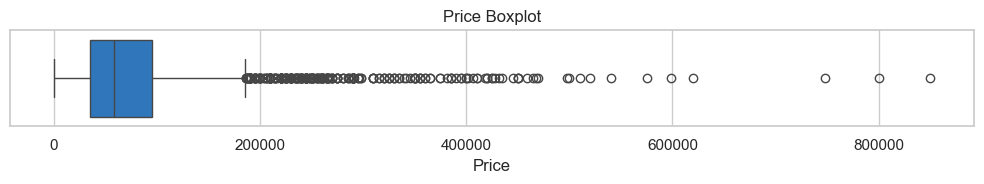

In [34]:
plot_box(df_clean_mileage['Price'], title='Price Boxplot', xlabel='Price')

In [35]:
# Descriptive statistics without scientific notation
with pd.option_context('display.float_format', '{:,.2f}'.format):
    print("Price descriptive stats:")
    print(df_clean_mileage['Price'].describe())

Price descriptive stats:
count     3,805.00
mean     78,144.31
std      72,581.44
min           1.00
25%      35,000.00
50%      58,000.00
75%      95,000.00
max     850,000.00
Name: Price, dtype: float64


In [36]:
# Calculate the 99.9th percentile of Price
price_999 = df_clean_mileage['Price'].quantile(0.999)

# Show data with Price above 99.9th percentile
high_price_cars = df_clean_mileage[df_clean_mileage['Price'] > price_999].sort_values(by='Price', ascending=False)
display(high_price_cars)

# Calculate the 0.1th percentile of Price
price_001 = df_clean_mileage['Price'].quantile(0.001)

# Show data with Price below 0.1th percentile
low_price_cars = df_clean_mileage[df_clean_mileage['Price'] < price_001].sort_values(by='Price', ascending=True)
display(low_price_cars)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price,Mileage_per_Year,Unnatural_High_Mileage_Flag
2401,Bentayga,Dammam,Bentley,Automatic,Saudi,Full,2019,6.0,13000,False,850000,4333.333333,False
3191,G,Riyadh,Mercedes,Automatic,Other,Full,2019,4.0,39000,False,800000,13000.000000,False
2912,S,Dammam,Mercedes,Automatic,Gulf Arabic,Full,2021,3.0,2500,False,748000,2500.000000,False
1438,Ghost,Dammam,Rolls-Royce,Automatic,Saudi,Full,2016,6.0,40000,False,620000,6666.666667,False


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price,Mileage_per_Year,Unnatural_High_Mileage_Flag
2130,Yukon,Jubail,GMC,Automatic,Saudi,Full,2019,5.3,50000,False,1,16666.666667,False
2725,G80,Riyadh,Genesis,Automatic,Other,Semi Full,2018,3.8,170000,False,500,42500.000000,False
3003,Yaris,Riyadh,Toyota,Automatic,Saudi,Standard,2018,1.5,100000,False,850,25000.000000,False
3475,Rio,Arar,Kia,Automatic,Saudi,Standard,2019,1.4,55500,False,884,18500.000000,False


Looking at the top 0.1% prices, these listings are actually valid since they contain very high-end cars (Bentley, Mercedes, Rolls-Royce). With the Type & Make as the features, these prices will be of no problem.

However, looking at the bottom 0.1% prices, things are different. A car being listed at 1 SAR is the same as selling it for free. It could also be a way of the seller to say "Call me to negotiate the price ourselves" because the seller does not want the price to be negotiated in the website for some reasons. These possibilities make these listings arguably invalid. So, I will remove these 4 outliers.

In [37]:
df_cleaned = df_clean_mileage.drop(index=low_price_cars.index, columns=['Unnatural_High_Mileage_Flag', 'Mileage_per_Year'])
print(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3801 entries, 0 to 3823
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Type         3801 non-null   object 
 1   Region       3801 non-null   object 
 2   Make         3801 non-null   object 
 3   Gear_Type    3801 non-null   object 
 4   Origin       3801 non-null   object 
 5   Options      3801 non-null   object 
 6   Year         3801 non-null   int64  
 7   Engine_Size  3801 non-null   float64
 8   Mileage      3801 non-null   int64  
 9   Negotiable   3801 non-null   bool   
 10  Price        3801 non-null   int64  
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 330.4+ KB
None


In [38]:
df_cleaned.describe(include='all')

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
count,3801,3801,3801,3801,3801,3801,3801.000000,3801.000000,3.801000e+03,3801,3801.000000
unique,319,27,56,2,4,3,NaN,NaN,NaN,1,NaN
top,Land Cruiser,Riyadh,Toyota,Automatic,Saudi,Full,NaN,NaN,NaN,False,NaN
freq,148,1600,883,3401,2877,1464,NaN,NaN,NaN,3801,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2014.871613,3.181768,1.273882e+05,NaN,78225.955801
std,NaN,NaN,NaN,NaN,NaN,NaN,5.095079,1.459077,1.104290e+05,NaN,72575.944442
min,NaN,NaN,NaN,NaN,NaN,NaN,1963.000000,1.000000,1.000000e+02,NaN,950.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2013.000000,2.000000,4.800000e+04,NaN,35000.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2016.000000,2.700000,1.021090e+05,NaN,58000.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,4.000000,1.810000e+05,NaN,95000.000000


# Save cleaned dataset to a CSV

In [39]:
df_cleaned.to_csv(OUTPUT_PATH, index=False)
print(f"Final cleaned data saved to {OUTPUT_PATH}")

Final cleaned data saved to ../data/cleaned_outliers_data_saudi_used_cars.csv
